<a href="https://colab.research.google.com/github/fabiobif/SentPt/blob/main/SentPt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis with BERT for PT data

In [ ]:
!nvidia-smi

Mon Dec 13 11:41:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Dec 13 11:41:32 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [ ]:
!pip install watermark

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.8.2
    Uninstalling importlib-metadata-4.8.2:
      Successfully uninstalled importlib-metadata-4.8.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.2 which is incompatible.


In [ ]:
#numpy 1.18.2
#pandas 1.0.3
#torch 1.4.0
#transformers 2.8.0

In [ ]:
#!pip install torch==1.4.0
!pip install torch

In [ ]:
#!pip install pandas==1.0.3
!pip install pandas

In [ ]:
#!pip install numpy==1.18.2
!pip install numpy

In [ ]:
#!pip install transformers==2.8.0
!pip install transformers==2.8.0

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.19.5
pandas      : 1.1.5
torch       : 1.10.0+cu111
transformers: 2.8.0



In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration


In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_datasets/Sentiment-pt/sentiment_data_pt7.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191371 entries, 0 to 191370
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Sentence  191370 non-null  object 
 1   V         191371 non-null  float64
 2   Label     191371 non-null  float64
dtypes: float64(2), object(1)
memory usage: 4.4+ MB


The balance was (mostly) restored.

## Data Preprocessing


In [ ]:
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [ ]:
sample_txt = 'Olá este é apenas um texte para.'

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: Olá este é apenas um texte para.
   Tokens: ['Ol', '##á', 'este', 'é', 'apenas', 'um', 'tex', '##te', 'para', '.']
Token IDs: [1651, 22303, 860, 253, 820, 222, 4509, 185, 221, 119]


In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
df

,Sentence,V,Label
0,desfalecida,0.000,0.0
1,Se o cartel conseguir chantagear as autoridad...,0.510,1.0
2,Meu pai me levou para ver esse filme quando fo...,0.000,2.0
3,Um filme incomum para um público fora dos EUA....,0.000,2.0
4,não for levado a sério não ser levado a sério,0.000,0.0
...,...,...,...
191366,imitámo,0.500,1.0
191367,Não chore confie em mim,0.500,1.0
191368,ultrajámos,0.500,1.0
191369,passas desta para melhor passar desta para melhor,0.000,0.0


In [ ]:
check_for_nan = df.Sentence.isnull().values.any()
print (check_for_nan)

True


In [ ]:
df = df.dropna(subset=["Sentence"])

In [ ]:
df

,Sentence,V,Label
0,desfalecida,0.000,0.0
1,Se o cartel conseguir chantagear as autoridad...,0.510,1.0
2,Meu pai me levou para ver esse filme quando fo...,0.000,2.0
3,Um filme incomum para um público fora dos EUA....,0.000,2.0
4,não for levado a sério não ser levado a sério,0.000,0.0
...,...,...,...
191366,imitámo,0.500,1.0
191367,Não chore confie em mim,0.500,1.0
191368,ultrajámos,0.500,1.0
191369,passas desta para melhor passar desta para melhor,0.000,0.0


In [ ]:
token_lens = []

for txt in df.Sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

and plot the distribution:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


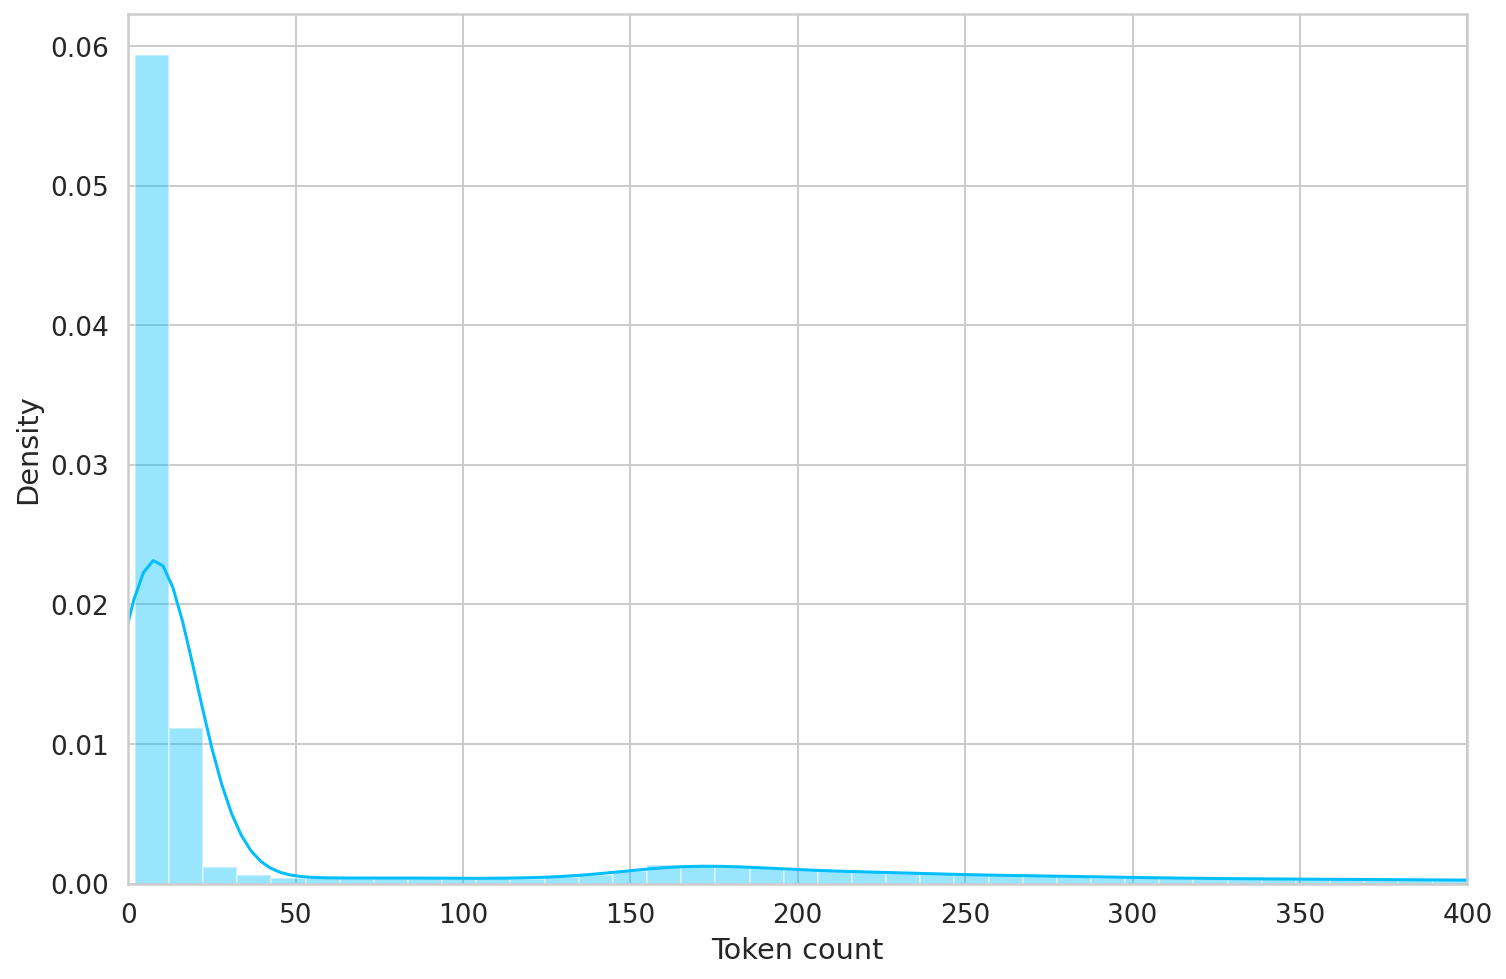

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 400]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 300
#MAX_LEN = 180

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=RANDOM_SEED, stratify=df.Label)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED, stratify=df_test.Label)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((162664, 3), (14353, 3), (14353, 3))

In [ ]:
df_test

,Sentence,V,Label
124247,mostraria atitude mostrar atitude,1.0,2.0
34106,não teríamos onde cair morto não ter onde cair...,0.0,0.0
122777,Este straight-to-video duffer é outro prego no...,0.0,0.0
117659,Isso não é ótimo cinema. O filme é clichês e e...,0.0,0.0
180090,ludibrioso,0.0,0.0
...,...,...,...
185354,vomitasses vomitarse,0.0,0.0
89052,intempestivo intempestivo,0.0,0.0
25335,Ele estava ligando para bases em todo os Estad...,0.6,1.0
64278,Eu realmente devo ter pegado um filme diferent...,0.0,0.0


We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.Sentence.to_numpy(),
    targets=df.Label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 300])
torch.Size([16, 300])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/647 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [ ]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 300])
torch.Size([16, 300])


In [ ]:
print(input_ids)

tensor([[  101,  2471,   123,  ...,     0,     0,     0],
        [  101,  2533,   784,  ...,     0,     0,     0],
        [  101,   346, 16649,  ...,     0,     0,     0],
        ...,
        [  101, 16936, 18613,  ...,     0,     0,     0],
        [  101,   349,  2373,  ...,     0,     0,     0],
        [  101,  8573,   147,  ...,     0,     0,     0]], device='cuda:0')


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3172, 0.2990, 0.3838],
        [0.3047, 0.3043, 0.3909],
        [0.3778, 0.2955, 0.3267],
        [0.3785, 0.2868, 0.3347],
        [0.3796, 0.3060, 0.3144],
        [0.3236, 0.2819, 0.3946],
        [0.3136, 0.3275, 0.3589],
        [0.3686, 0.2563, 0.3751],
        [0.4291, 0.2670, 0.3039],
        [0.4832, 0.2043, 0.3125],
        [0.3093, 0.3262, 0.3645],
        [0.3785, 0.3035, 0.3181],
        [0.3033, 0.3579, 0.3387],
        [0.3744, 0.2759, 0.3496],
        [0.3491, 0.3073, 0.3437],
        [0.2764, 0.3504, 0.3733]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state7')
    torch.save(model.state_dict(), 'best_model_state7.pth')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss 0.3243285980465321 accuracy 0.868446613878916
Val   loss 0.23258200614867533 accuracy 0.9085208667177593

Epoch 2/5
----------
Train loss 0.1904297859428406 accuracy 0.9317181429203757
Val   loss 0.27088164726783587 accuracy 0.9154880512784784

Epoch 3/5
----------
Train loss 0.13277402225856205 accuracy 0.9580546402400039
Val   loss 0.35659008541502457 accuracy 0.9166724726538006

Epoch 4/5
----------
Train loss 0.09515929566580553 accuracy 0.9734237446515516
Val   loss 0.40184790236950935 accuracy 0.9198077057061241

Epoch 5/5
----------
Train loss 0.06969448801848836 accuracy 0.9818460138690798
Val   loss 0.43193390655254965 accuracy 0.9213404863094824

CPU times: user 7h 36min 48s, sys: 1min 19s, total: 7h 38min 7s
Wall time: 7h 36min 33s


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

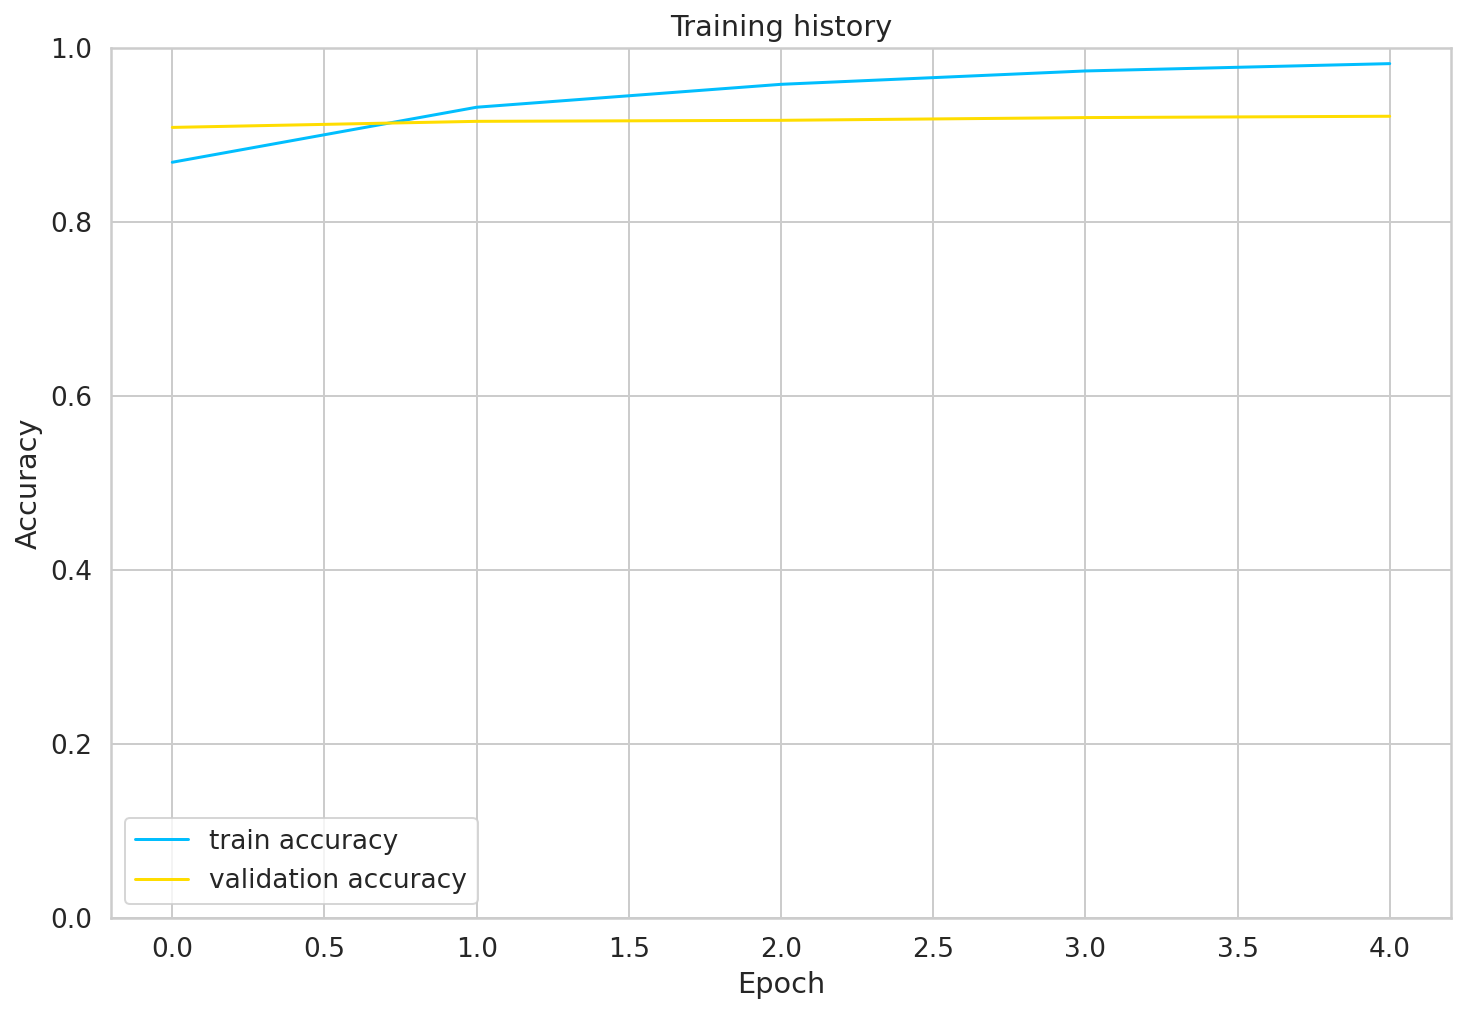

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

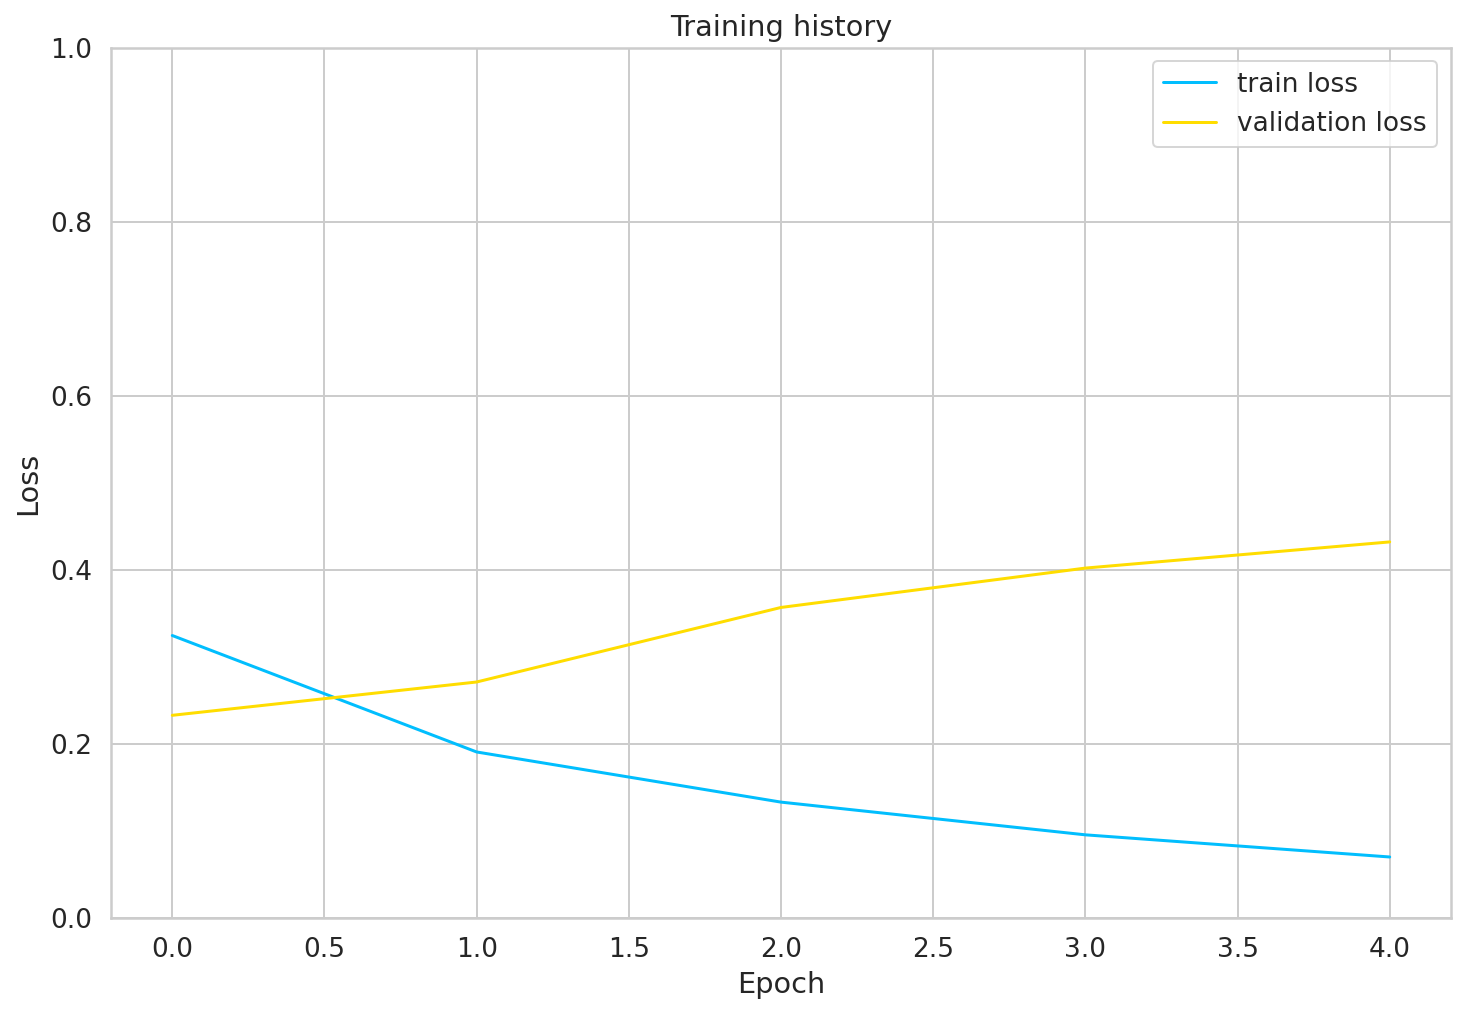

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

In [ ]:
print(history.keys())

dict_keys(['train_acc', 'train_loss', 'val_acc', 'val_loss'])


## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9202257367797673

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.96      0.95      0.95      6972
     neutral       0.87      0.86      0.86      2774
    positive       0.90      0.91      0.90      4607

    accuracy                           0.92     14353
   macro avg       0.91      0.91      0.91     14353
weighted avg       0.92      0.92      0.92     14353



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

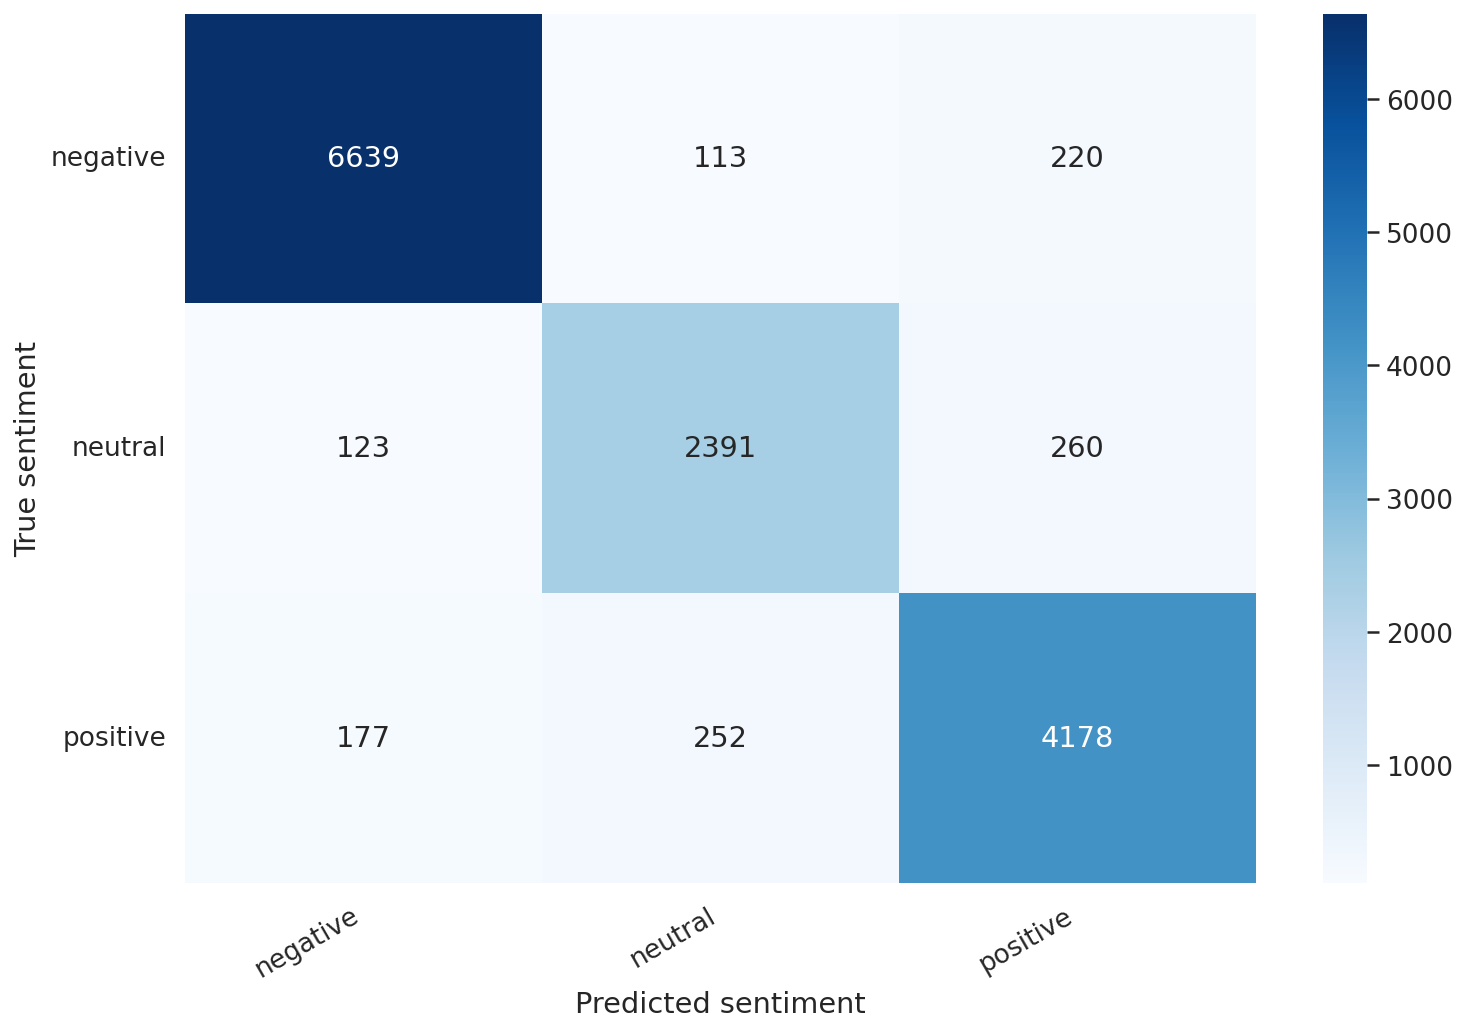

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 5

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

obscurecem

True sentiment: neutral


Now we can look at the confidence of each sentiment of our model:

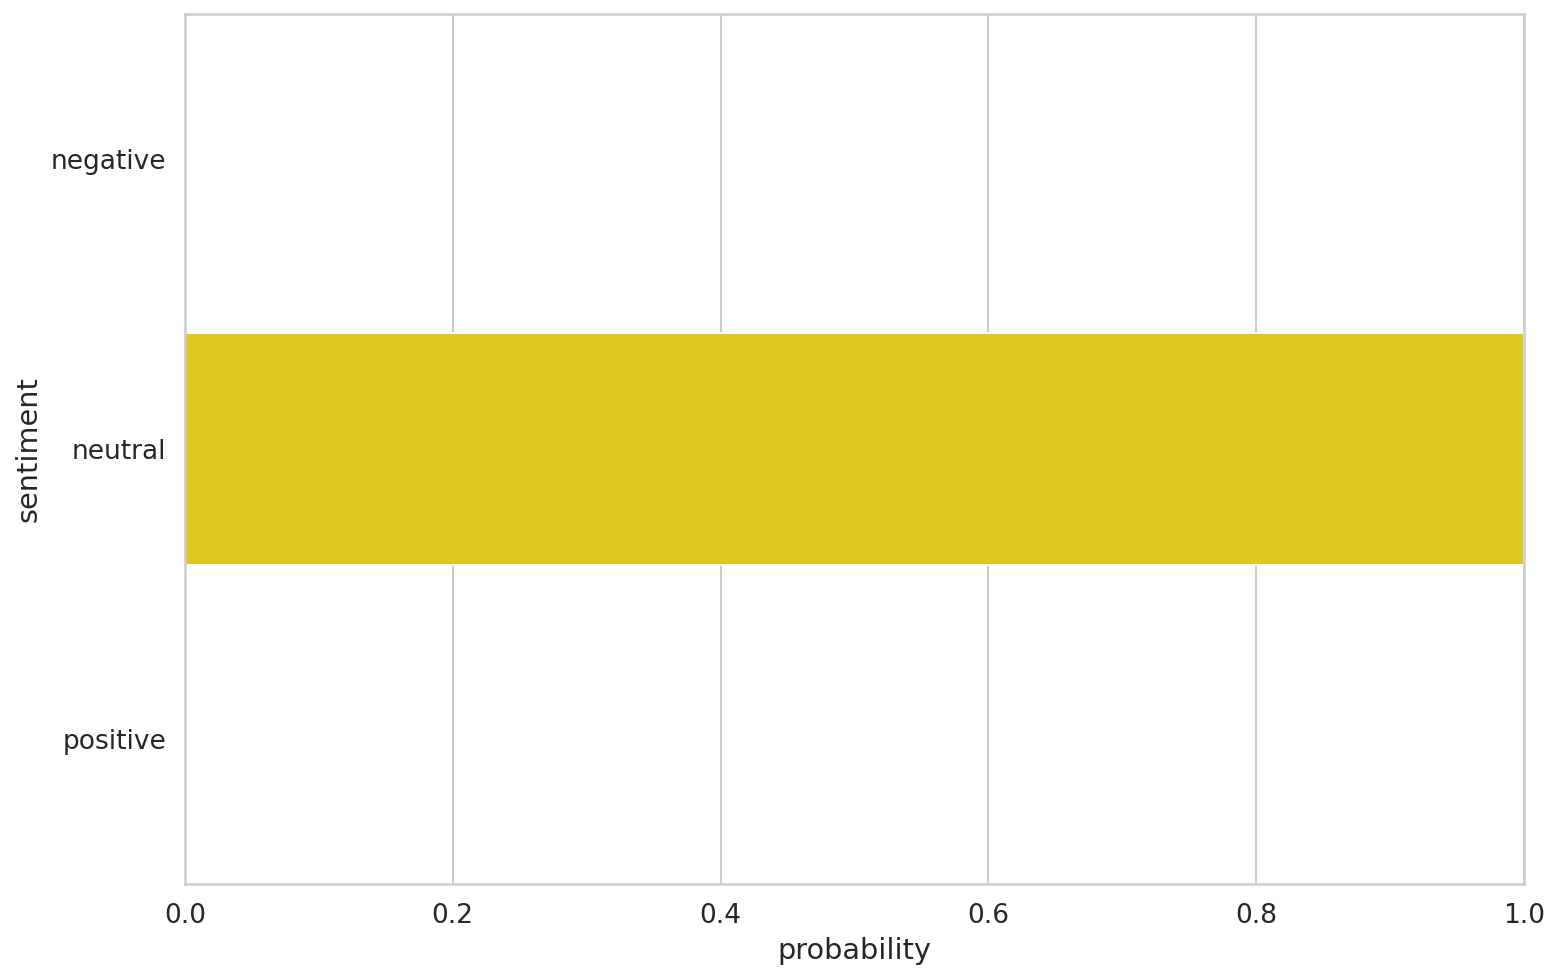

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "Eu amo completamente este app! O melhor de todos sempre!"
#review_text = "Eu quero ir para o outro mundo!"
#review_text = "acabar por tirar a vida dele"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: Eu amo completamente este app! O melhor de todos sempre!
Sentiment  : positive


In [ ]:
column = ['Sentence']
#dfPT = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LREC2022/Datasets_samples_test/b2w-sampleTest.tsv",sep="\t",header=None, names=column)
#dfPT = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LREC2022/Datasets_samples_test/buscape-sampleTest.tsv",sep="\t",header=None, names=column)
#dfPT = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LREC2022/Datasets_samples_test/olist-sampleTest.tsv",sep="\t",header=None, names=column)
#dfPT = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LREC2022/Datasets_samples_test/utlc_apps-sampleTest.tsv",sep="\t",header=None, names=column)
dfPT = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LREC2022/Datasets_samples_test/utlc_movies-sampleTest.tsv",sep="\t",header=None, names=column)

dfPT.head()

,Sentence
0,O inseto faz sons para tentar acasalar com a J...
1,Pode ser chamado também de estupro emocional
2,"Mais uma ótima animação da DC, e que bom ver o..."
3,Ohana E o melhor Elvis Cover da história do en...
4,Que filme/desfecho maravilhoso Um dos mais lin...


In [ ]:
def sentClassifier(input_text):

  #model.eval()
    
  encoded_review = tokenizer.encode_plus(
    input_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
  )

    
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  #input_ids, attention_mask

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  print(f"Review text: {input_text}, Sentiment  : '{class_names[prediction]}'")

  return class_names[prediction]

In [ ]:
dfTest = dfPT
dfTest.shape

(384, 1)

In [ ]:
dfTest['Sentiment'] = dfTest.Sentence.apply(lambda x: sentClassifier(x))

Review text: O inseto faz sons para tentar acasalar com a Jennifer Connelly heuheuheuehuheuheuheuheuótimo filme, Sentiment  : 'positive'
Review text: Pode ser chamado também de estupro emocional, Sentiment  : 'neutral'
Review text: Mais uma ótima animação da DC, e que bom ver o foco em outro personagem no caso aqui, o Flash , ao invés de Batman e Superman Algumas mudanças em relação à boa obra original, mas nada que incomode Curti o tom mais violento também, mas só não leva mais pontos pela arte, que é muito ruim, às vezes os personagens pareciam deformados E continuo insistindo As animações da DC qualquer filme live action da Marvel, Sentiment  : 'positive'
Review text: Ohana E o melhor Elvis Cover da história do entretenimento, Sentiment  : 'positive'
Review text: Que filme/desfecho maravilhoso Um dos mais lindos e emocionantes que já vi, e um dos mais justos também Cada um mereceu o desfecho que foi dado, exceto aos que morreram Que foi um dos motivos que me fez ter amor e ódio por 

In [ ]:
dfTest

,Sentence,Sentiment
0,O inseto faz sons para tentar acasalar com a J...,positive
1,Pode ser chamado também de estupro emocional,neutral
2,"Mais uma ótima animação da DC, e que bom ver o...",positive
3,Ohana E o melhor Elvis Cover da história do en...,positive
4,Que filme/desfecho maravilhoso Um dos mais lin...,positive
...,...,...
379,Entendi nada e gostei de tudo,positive
380,Gostei bastante Ótimo suspense Final imprevisí...,positive
381,PERFEITO,positive
382,"A cena do Oskar saindo da piscina é muito boa,...",positive


In [ ]:
#dfTest.to_csv('/content/drive/MyDrive/Colab Notebooks/LREC2022/b2wSentPT9_predict.tsv', sep = '\t', index=False)
#dfTest.to_csv('/content/drive/MyDrive/Colab Notebooks/LREC2022/buscapeSentPT9_predict.tsv', sep = '\t', index=False)
#dfTest.to_csv('/content/drive/MyDrive/Colab Notebooks/LREC2022/olistSentPT9_predict.tsv', sep = '\t', index=False)
#dfTest.to_csv('/content/drive/MyDrive/Colab Notebooks/LREC2022/utlc_appsSentPT9_predict.tsv', sep = '\t', index=False)
dfTest.to_csv('/content/drive/MyDrive/Colab Notebooks/LREC2022/utlc_moviesSentPT9_predict.tsv', sep = '\t', index=False)